In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [5]:
dir = os.listdir("../data/predict_image")
print(dir)

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', 'output_team.xlsx']


In [9]:
image_name=[]
for i in range(len(dir)-1):
    image_name.append(dir[i])
    print(image_name[i])
image_name = np.array(image_name)
df = pd.DataFrame(image_name)
df.to_csv("../data/prediction", index=False)

0001.jpg
0002.jpg
0003.jpg
0004.jpg
0005.jpg
0006.jpg
0007.jpg
0008.jpg
0009.jpg
0010.jpg


                           filename  width  height   class  xmin  ymin  xmax  \
0  01a9c84cf8d5523da74a5a3e3ddc535f   2500    1667  Rafale  1992   829  2349   
1  01a9c84cf8d5523da74a5a3e3ddc535f   2500    1667  Rafale   423   919   765   
2  01a9c84cf8d5523da74a5a3e3ddc535f   2500    1667   A400M   721   521  2056   

   ymax  
0   961  
1  1048  
2   887  


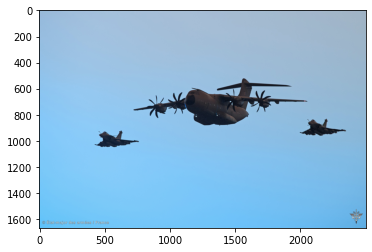

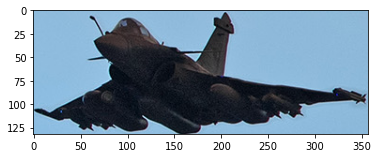

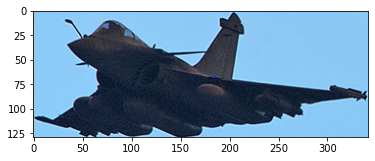

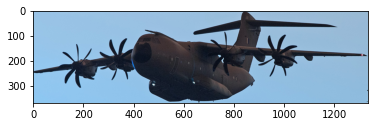

['0000', '0001', '0002']


In [34]:
name = "01a9c84cf8d5523da74a5a3e3ddc535f"
csv = pd.read_csv("../data/militaryaircraftdetectiondataset/dataset/"+name+".csv")
image = cv2.imread("../data/militaryaircraftdetectiondataset/dataset/"+name+".jpg")
print(csv)
plt.imshow(image)
plt.show()
crop_image=[]
save_name = []
for i in range(len(csv)):
    xmin = csv["xmin"][i]
    xmax = csv["xmax"][i]
    ymin = csv["ymin"][i]
    ymax = csv["ymax"][i]
    crop_image.append(image[ymin:ymax,xmin:xmax])
for i in range(len(crop_image)):
    z = i//10
    pad = (3-z)*"0"
    save_name.append(pad+str(i)+".jpg")
    plt.imshow(crop_image[i])
    plt.show()
print(save_name)
save_name = np.array(save_name)
df = pd.DataFrame(save_name)
df.to_csv("../data/prediction.csv", index=False)

In [10]:
import os
import pandas as pd
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as tx
import torchvision.transforms as T
import numpy as np
from torch import nn
from torchmetrics import Accuracy
from PIL import Image
import random

In [11]:
few_data = False
data_num = 100
batch_size = 10

In [12]:
class_map=['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C5', 'E2', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'Mig31', 'Mirage2000', 'MQ9', 'Rafale', 'RQ4', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan', 'XB70', 'YF23']




In [13]:
global_mean = [120.74446532507794, 129.82000781821228, 138.8076694793008]
global_std = [51.8159762582478, 51.42346227240079, 52.72563864069662]

In [55]:
class MyDataset():
    def __init__(self, csv_file, augment=False):
        if few_data:
            self.df = pd.read_csv(csv_file).iloc[:data_num]
        else:
            self.df = pd.read_csv(csv_file)
        self.image_size=256
        self.mean = np.array(global_mean, dtype=np.float32)
        self.std = np.array(global_std, dtype=np.float32)
        self.augment = augment
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
#         label = self.df["type"][idx]
        image_name = self.df["0"][idx]
#         path = 
        image = cv2.imread("../data/predict_image/"+image_name)
        image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        image = Image.fromarray(image)
        if self.augment:
            image = augmentation(image)
        image = tx.to_tensor(image)
        image = tx.resize(image, (self.image_size, self.image_size))
        image = tx.normalize(image, self.mean/255, self.std/255) 
#         image = tx.to_tensor(image)
        return image, image_name

In [56]:
test_dataset = MyDataset("../data/prediction")
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

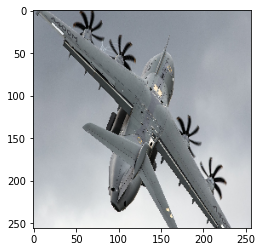

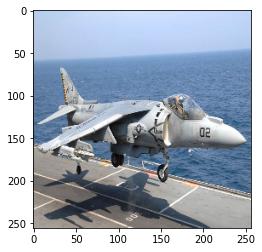

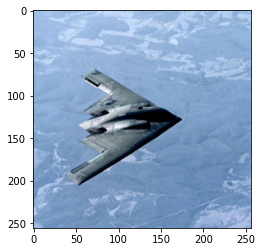

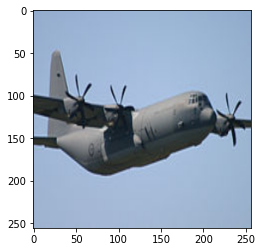

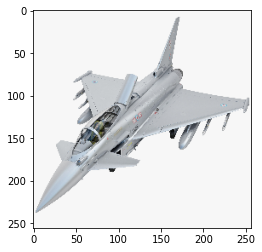

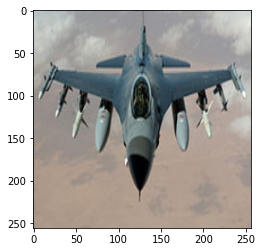

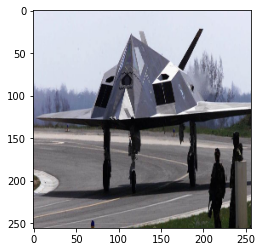

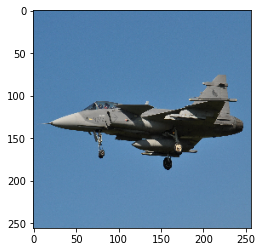

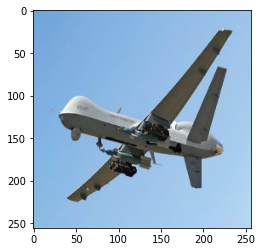

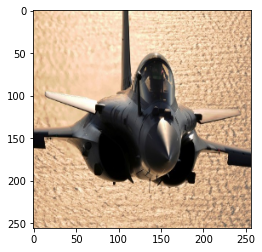

In [57]:
image, image_name = next(iter(test_dataloader))
# print(len(test_dataset))

In [48]:
model = torchvision.models.efficientnet_b6(pretrained=True)
model.classifier = torch.nn.Linear(2304, 40, bias=True)
model.load_state_dict(torch.load("../data/models/best.pth"))

<All keys matched successfully>

In [49]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
model.to(device)
print(device)

cuda


In [51]:
def test(dataloader, loss_fn,model):
    model.eval()
    total_loss = 0
    total_acc = 0
    prediction=[]
    for i, (image,image_name) in enumerate(dataloader):
        image = image.to(device)
#         label = label.to(device)
        pred = model(image)
        pred = torch.argmax(pred, axis = 1)
        prediction.append(pred)
        print(pred)
        print(image_name)
    return prediction

In [52]:
prediction = test(test_dataloader, loss_fn, model)

tensor([ 1,  3,  5,  8, 12, 16, 13, 22, 25, 14], device='cuda:0')
('0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg')


In [53]:
prediction[0][0]

tensor(1, device='cuda:0')

In [54]:
for i in range(len(prediction[0])):
    print(class_map[prediction[0][i]])

A400M
AV8B
B2
C130
EF2000
F16
F117
JAS39
MQ9
F14
